In [102]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sqlite3
import datetime
from sklearn import preprocessing
from finrl.config import config
from finrl.preprocessing.preprocessors import FeatureEngineer
from finrl.preprocessing.data import data_split
from finrl.env.env_stocktrading import StockTradingEnv
from finrl.model.models import DRLAgent
from finrl.trade.backtest import backtest_stats, get_baseline, backtest_plot
# Diable the warnings
import warnings
warnings.filterwarnings('ignore')

In [103]:
# set the period
start = '2019-12-31'
end = '2020-12-31'
# d1 = start.strftime('%Y-%m-%d')
# d2 = end.strftime('%Y-%m-%d')

# collect to historical
stock = 'MSFT'
db = sqlite3.connect("db3.db")
dataSet = pd.read_sql(
    con=db,
    sql=f'SELECT date, Open, High, Low, Close, Volume  FROM "{stock}" WHERE Date BETWEEN  "{start}" and "{end}"')
dataSet['tic'] = stock
dataSet.columns = ['date','open','high','low','close','volume','tic']

In [107]:
tech_indicator_list = ["macd","boll_ub","boll_lb","rsi_30","cci_30", "dx_30","close_30_sma",'kdjk','kdjd','kdjj', 'open_2_sma', 'boll','wr_30','wr_10','dma','rsi_14']
fe = FeatureEngineer(use_technical_indicator=True, tech_indicator_list=tech_indicator_list, use_turbulence=False,
                     user_defined_feature=False)
processeDataSet = fe.preprocess_data(dataSet)
trade = data_split(processeDataSet, start='2020-01-01', end='2020-12-31')
feature_list = list(trade.columns)
feature_list.remove('date')
feature_list.remove('tic')
feature_list.remove('close')
print(feature_list)

data_normaliser = preprocessing.StandardScaler()
data_normaliser.fit(trade[feature_list])
trade[feature_list] = data_normaliser.transform(trade[feature_list])

Successfully added technical indicators
['open', 'high', 'low', 'volume', 'macd', 'boll_ub', 'boll_lb', 'rsi_30', 'cci_30', 'dx_30', 'close_30_sma', 'kdjk', 'kdjd', 'kdjj', 'open_2_sma', 'boll', 'wr_30', 'wr_10', 'dma', 'rsi_14']


In [108]:
stock_dimension = len(trade.tic.unique())
state_space = 1 + 2 * stock_dimension + len(tech_indicator_list) * stock_dimension
env_kwargs = {
    "hmax": 1000000,
    "initial_amount": 100000,
    "buy_cost_pct": 0.0,
    "sell_cost_pct": 0.0008,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": tech_indicator_list,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}

e_trade_gym = StockTradingEnv(df=trade, **env_kwargs)
env_trade,_ = e_trade_gym.get_sb_env()
agent = DRLAgent(env=env_trade)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.005,
    "learning_rate": 0.0025,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)
load_ppo = model_ppo.load('trained_models/2009-2019_MSFT_2021_4_23_ppo.model')

{'n_steps': 2048, 'ent_coef': 0.005, 'learning_rate': 0.0025, 'batch_size': 128}
Using cpu device


In [120]:
average = pd.DataFrame()
for i in range(100):
    df_account_value, df_actions = DRLAgent.DRL_prediction(model=load_ppo, environment=e_trade_gym)
    print("==============Get Backtest Results===========")
    now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')
    perf_stats_all = backtest_stats(account_value=df_account_value)
    perf_stats_all = pd.DataFrame(perf_stats_all)
    average = average.append({'return':perf_stats_all[0]["Annual return"]}, ignore_index=True)
# print(f"==============Compare to {stock} itself buy-and-hold===========")
# %matplotlib inline
# backtest_plot(account_value=df_account_value, 
#              baseline_ticker = stock,
#              baseline_start = '2019-01-01',
#              baseline_end = '2019-12-31')

hit end!
==============Get Backtest Results===========
Annual return         -0.071861
Cumulative returns    -0.071861
Annual volatility      0.370790
Sharpe ratio          -0.016038
Calmar ratio          -0.234158
Stability              0.114883
Max drawdown          -0.306891
Omega ratio            0.996223
Sortino ratio         -0.022533
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.905078
Daily value at risk   -0.046739
dtype: float64
hit end!
==============Get Backtest Results===========
Annual return          0.033815
Cumulative returns     0.033815
Annual volatility      0.337912
Sharpe ratio           0.266101
Calmar ratio           0.124279
Stability              0.001705
Max drawdown          -0.272089
Omega ratio            1.061092
Sortino ratio          0.387136
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.842965
Daily value at risk   -0.042216
dtype: float64
hit end!
==============Get B

Annual return          0.113133
Cumulative returns     0.113133
Annual volatility      0.349791
Sharpe ratio           0.483776
Calmar ratio           0.492340
Stability              0.080439
Max drawdown          -0.229786
Omega ratio            1.119318
Sortino ratio          0.693099
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.070123
Daily value at risk   -0.043398
dtype: float64
hit end!
==============Get Backtest Results===========
Annual return          0.330214
Cumulative returns     0.330214
Annual volatility      0.334951
Sharpe ratio           1.024941
Calmar ratio           1.784058
Stability              0.606917
Max drawdown          -0.185091
Omega ratio            1.260750
Sortino ratio          1.462711
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.968391
Daily value at risk   -0.040838
dtype: float64
hit end!
==============Get Backtest Results===========
Annual return          0.402

hit end!
==============Get Backtest Results===========
Annual return          0.406706
Cumulative returns     0.406706
Annual volatility      0.349360
Sharpe ratio           1.152818
Calmar ratio           1.768312
Stability              0.589306
Max drawdown          -0.229997
Omega ratio            1.285380
Sortino ratio          1.882756
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.037497
Daily value at risk   -0.042417
dtype: float64
hit end!
==============Get Backtest Results===========
Annual return          0.522919
Cumulative returns     0.522919
Annual volatility      0.372882
Sharpe ratio           1.319353
Calmar ratio           3.551587
Stability              0.809183
Max drawdown          -0.147235
Omega ratio            1.369173
Sortino ratio          2.024422
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.118129
Daily value at risk   -0.045026
dtype: float64
hit end!
==============Get B

hit end!
==============Get Backtest Results===========
Annual return          0.014747
Cumulative returns     0.014747
Annual volatility      0.366105
Sharpe ratio           0.223615
Calmar ratio           0.082699
Stability              0.006248
Max drawdown          -0.178323
Omega ratio            1.054005
Sortino ratio          0.317715
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.031530
Daily value at risk   -0.045800
dtype: float64
day: 251, episode: 780
begin_total_asset: 100000.00
end_total_asset: 107219.17
total_reward: 7219.17
total_cost: 5864.08
total_trades: 224
Sharpe: 0.371
hit end!
==============Get Backtest Results===========
Annual return          0.072192
Cumulative returns     0.072192
Annual volatility      0.368505
Sharpe ratio           0.371319
Calmar ratio           0.362213
Stability              0.002699
Max drawdown          -0.199307
Omega ratio            1.089549
Sortino ratio          0.569801
Skew              

hit end!
==============Get Backtest Results===========
Annual return          0.178029
Cumulative returns     0.178029
Annual volatility      0.340195
Sharpe ratio           0.652886
Calmar ratio           0.686340
Stability              0.385293
Max drawdown          -0.259389
Omega ratio            1.154789
Sortino ratio          0.971647
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.094027
Daily value at risk   -0.041979
dtype: float64
hit end!
==============Get Backtest Results===========
Annual return          0.695195
Cumulative returns     0.695195
Annual volatility      0.350131
Sharpe ratio           1.686463
Calmar ratio           5.200083
Stability              0.872217
Max drawdown          -0.133689
Omega ratio            1.480824
Sortino ratio          2.895391
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.341091
Daily value at risk   -0.041769
dtype: float64
hit end!
==============Get B

hit end!
==============Get Backtest Results===========
Annual return          0.145631
Cumulative returns     0.145631
Annual volatility      0.343579
Sharpe ratio           0.566297
Calmar ratio           0.746577
Stability              0.525900
Max drawdown          -0.195065
Omega ratio            1.137017
Sortino ratio          0.888231
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.808944
Daily value at risk   -0.042515
dtype: float64
hit end!
==============Get Backtest Results===========
Annual return          0.123054
Cumulative returns     0.123054
Annual volatility      0.351822
Sharpe ratio           0.503847
Calmar ratio           0.526386
Stability              0.312580
Max drawdown          -0.233771
Omega ratio            1.122489
Sortino ratio          0.802893
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.958719
Daily value at risk   -0.043622
dtype: float64
hit end!
==============Get B

In [124]:
print(average['return'].mean())
print(average['return'].median())
print(average['return'].max())
print(average['return'].min())

0.2690850517867201
0.23173241298824843
1.1136584597440997
-0.23727930163559663


In [176]:
df_account_value, df_actions = DRLAgent.DRL_prediction(model=load_ppo, environment=e_trade_gym)
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')
perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)

day: 251, episode: 1080
begin_total_asset: 100000.00
end_total_asset: 182694.14
total_reward: 82694.14
total_cost: 6913.41
total_trades: 224
Sharpe: 1.888
hit end!
==============Get Backtest Results===========
Annual return          0.826941
Cumulative returns     0.826941
Annual volatility      0.353241
Sharpe ratio           1.887549
Calmar ratio           3.786583
Stability              0.852694
Max drawdown          -0.218387
Omega ratio            1.529871
Sortino ratio          3.316048
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.311466
Daily value at risk   -0.041858
dtype: float64


==============Compare to MSFT itself buy-and-hold===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (253, 8)


Start date,2020-01-02
End date,2020-12-30
Total months,12
,Backtest
Annual return,82.7%
Cumulative returns,82.7%
Annual volatility,35.3%
Sharpe ratio,1.89
Calmar ratio,3.79
Stability,0.85
Max drawdown,-21.8%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,21.84,2020-02-04,2020-03-12,2020-03-24,36
1,10.53,2020-10-13,2020-11-03,2020-12-28,55
2,6.74,2020-09-02,2020-09-24,2020-10-12,29
3,6.22,2020-04-17,2020-05-28,2020-06-10,39
4,5.99,2020-08-06,2020-08-11,2020-08-25,14


Stress Events,mean,min,max
New Normal,0.26%,-9.47%,14.20%


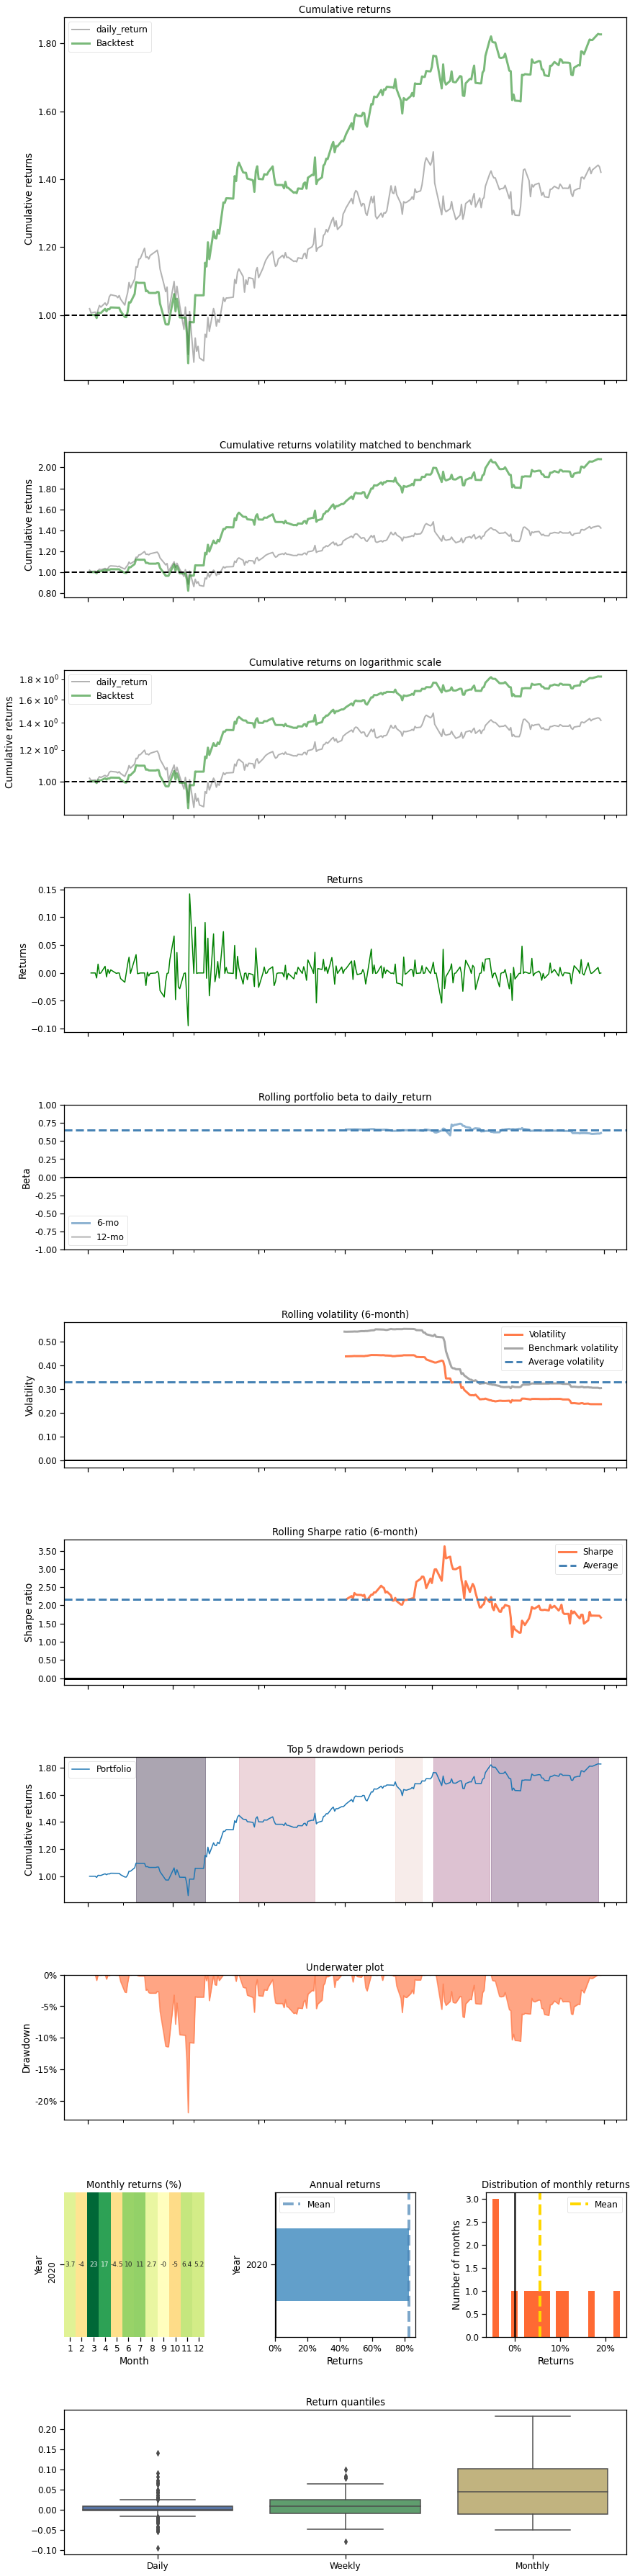

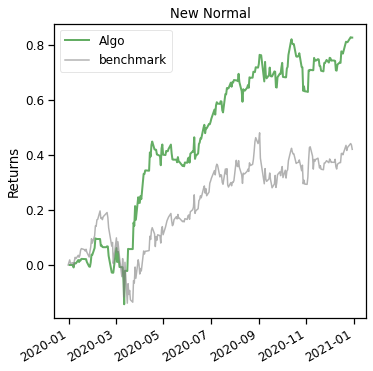

In [177]:
perf_stats_all.to_csv("./"+config.RESULTS_DIR+"/2009-2019_MSFT_2021_4_24_ppo_"+now+'.csv')
print(f"==============Compare to {stock} itself buy-and-hold===========")
%matplotlib inline
backtest_plot(account_value=df_account_value, 
             baseline_ticker = stock,
             baseline_start = '2020-01-01',
             baseline_end = '2020-12-31')